# Credit Default Risk Prediction — Home Credit Indonesia
### Business-Driven Data Science Project | End-to-End Machine Learning Workflow

## Project Overview & Business Objective

**The Core Challenge:**
In the competitive landscape of consumer lending, **Home Credit Indonesia** faces a critical optimization problem:
*   **Risk Minimization:** Avoiding approval of applicants who are likely to default (minimize Non-Performing Loans/NPL).
*   **Revenue Maximization:** Ensuring creditworthy applicants are not incorrectly rejected (maximize Growth Opportunities).

**The Objective:**
To develop a robust, high-performance **Credit Risk Scoring Model** using advanced Machine Learning techniques. This model will not just predict a binary outcome but provide a **calibrated risk probability**, enabling the business to set dynamic approval thresholds that align with financial strategy (e.g., maximizing profit margin vs. minimizing risk).

## Notebook Highlights & Innovations

1.  **Deep Business-Centric EDA:** Beyond simple charts, we analyze the financial impact of features.
2.  **Feature Aggregation Strategy:** Advanced handling of one-to-many relational data (Bureau, Installments).
3.  **Memory-Efficient Checkpointing:** A robust system to handle large datasets on standard hardware (saving progress at key stages).
4.  **Profitability Simulation:** A custom module to translate model metrics (AUC) into projected financial value (IDR).

## Table of Contents (Execution Flow)

**STAGE 1: Data Loading & Exploration**

1. Configuration
2. Data Loading
3. Schema Checks
4. Target Analysis
5. Missing Values
6. Memory Audit

**STAGE 2: Baseline Modeling**

7. Train-Val Split
8. Logistic Regression (Baseline)
9. Random Forest (Benchmark)

**STAGE 3: Advanced Feature Engineering**

10. Installments Feats
11. Bureau Feats
12. **Checkpointing** (Save Intermediates)

**STAGE 4: Final Modeling & Business Value**

13. Load Checkpoints
14. HistGradientBoosting
15. Feature Importance
16. Calibration
17. **Profit Simulation**

---

# STAGE 1: Data Loading & Exploration

> **Note**: This stage loads all data and requires ~8GB RAM

## 1. Configuration & Setup

In [2]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.calibration import CalibrationDisplay

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Imports loaded successfully.")

Imports loaded successfully.


In [3]:
DATA_DIR = Path("./data")
OUTPUT_DIR = Path("./outputs")
FIG_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

CHK_TRAIN_INST = OUTPUT_DIR / 'train_inst.parquet'
CHK_TEST_INST  = OUTPUT_DIR / 'test_inst.parquet'
CHK_TRAIN_MASTER = OUTPUT_DIR / 'train_master.parquet'
CHK_TEST_MASTER  = OUTPUT_DIR / 'test_master.parquet'

USE_CACHE = True  # Set False to force rebuild

print("DATA_DIR:", DATA_DIR.resolve())
print("OUTPUT_DIR:", OUTPUT_DIR.resolve())
print()
print("Checkpoint status:")
print(f" - train_inst: {CHK_TRAIN_INST.exists()}")
print(f" - test_inst: {CHK_TEST_INST.exists()}")
print(f" - train_master: {CHK_TRAIN_MASTER.exists()}")
print(f" - test_master: {CHK_TEST_MASTER.exists()}")

DATA_DIR: /home/binorion/FINAL PROJECT HCI/GITHUB/data
OUTPUT_DIR: /home/binorion/FINAL PROJECT HCI/GITHUB/outputs

Checkpoint status:
 - train_inst: True
 - test_inst: True
 - train_master: True
 - test_master: True


In [4]:
def agg_numeric(df, group_key, prefix, agg_funcs=("mean", "max", "min", "sum")):
    """Aggregate numeric columns by group key."""
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != group_key]
    agg_dict = {c: list(agg_funcs) for c in num_cols}
    out = df.groupby(group_key).agg(agg_dict)
    out.columns = [f"{prefix}{col}_{stat}" for col, stat in out.columns]
    return out.reset_index()

def add_count(df, group_key, prefix):
    """Add count feature per group."""
    return df.groupby(group_key).size().reset_index(name=f"{prefix}count")

def memory_usage_mb(df):
    """Calculate memory usage in MB."""
    return df.memory_usage(deep=True).sum() / (1024**2)

print("Helper functions defined.")

Helper functions defined.


## 2. Load All Raw Data

Loading all 9 CSV files from the Home Credit dataset.

In [42]:
FILES = {
    "app_train": "application_train.csv",
    "app_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "previous_app": "previous_application.csv",
    "pos_cash": "POS_CASH_balance.csv",
    "installments": "installments_payments.csv",
    "credit_card": "credit_card_balance.csv",
    "sample_sub": "sample_submission.csv",
}

missing = [fname for fname in FILES.values() if not (DATA_DIR / fname).exists()]
if missing:
    raise FileNotFoundError(f"Missing files in {DATA_DIR}: {missing}")

print("Loading all CSV files...")

app_train = pd.read_csv(DATA_DIR / FILES["app_train"])
app_test = pd.read_csv(DATA_DIR / FILES["app_test"])
bureau = pd.read_csv(DATA_DIR / FILES["bureau"])
bureau_balance = pd.read_csv(DATA_DIR / FILES["bureau_balance"])
previous_app = pd.read_csv(DATA_DIR / FILES["previous_app"])
pos_cash = pd.read_csv(DATA_DIR / FILES["pos_cash"])
installments = pd.read_csv(DATA_DIR / FILES["installments"])
credit_card = pd.read_csv(DATA_DIR / FILES["credit_card"])
sample_sub = pd.read_csv(DATA_DIR / FILES["sample_sub"])

print("\nLoaded:")
for name, df in [
    ("app_train", app_train), ("app_test", app_test),
    ("bureau", bureau), ("bureau_balance", bureau_balance),
    ("previous_app", previous_app), ("pos_cash", pos_cash),
    ("installments", installments), ("credit_card", credit_card),
]:
    print(f"  {name:15s} shape={df.shape}")

Loading all CSV files...

Loaded:
  app_train       shape=(307511, 122)
  app_test        shape=(48744, 121)
  bureau          shape=(1716428, 17)
  bureau_balance  shape=(27299925, 3)
  previous_app    shape=(1670214, 37)
  pos_cash        shape=(10001358, 8)
  installments    shape=(13605401, 8)
  credit_card     shape=(3840312, 23)


## 3. Schema & Integrity Check

Validating primary keys and data integrity across all tables.

In [43]:
def quick_key_check(df, key_col, name):
    if key_col not in df.columns:
        print(f"[WARN] {name}: column '{key_col}' not found")
        return
    n = len(df)
    n_unique = df[key_col].nunique(dropna=False)
    n_na = df[key_col].isna().sum()
    print(f"{name:15s} | rows={n:>12,} | unique({key_col})={n_unique:>10,} | NA={n_na:,}")

print("=" * 70)
print("KEY INTEGRITY CHECK")
print("=" * 70)

quick_key_check(app_train, "SK_ID_CURR", "app_train")
quick_key_check(app_test, "SK_ID_CURR", "app_test")
print()
quick_key_check(bureau, "SK_ID_CURR", "bureau")
quick_key_check(bureau, "SK_ID_BUREAU", "bureau")
quick_key_check(bureau_balance, "SK_ID_BUREAU", "bureau_balance")
print()
quick_key_check(previous_app, "SK_ID_CURR", "previous_app")
quick_key_check(previous_app, "SK_ID_PREV", "previous_app")
print()
quick_key_check(installments, "SK_ID_CURR", "installments")
quick_key_check(installments, "SK_ID_PREV", "installments")
print()
quick_key_check(pos_cash, "SK_ID_CURR", "pos_cash")
quick_key_check(credit_card, "SK_ID_CURR", "credit_card")

# Duplicate check
print("\n" + "=" * 70)
print("DUPLICATE CHECK ON APPLICATION TABLES")
print("=" * 70)
print(f"Duplicates in app_train: {app_train['SK_ID_CURR'].duplicated().sum()}")
print(f"Duplicates in app_test: {app_test['SK_ID_CURR'].duplicated().sum()}")

KEY INTEGRITY CHECK
app_train       | rows=     307,511 | unique(SK_ID_CURR)=   307,511 | NA=0
app_test        | rows=      48,744 | unique(SK_ID_CURR)=    48,744 | NA=0

bureau          | rows=   1,716,428 | unique(SK_ID_CURR)=   305,811 | NA=0
bureau          | rows=   1,716,428 | unique(SK_ID_BUREAU)= 1,716,428 | NA=0
bureau_balance  | rows=  27,299,925 | unique(SK_ID_BUREAU)=   817,395 | NA=0

previous_app    | rows=   1,670,214 | unique(SK_ID_CURR)=   338,857 | NA=0
previous_app    | rows=   1,670,214 | unique(SK_ID_PREV)= 1,670,214 | NA=0

installments    | rows=  13,605,401 | unique(SK_ID_CURR)=   339,587 | NA=0
installments    | rows=  13,605,401 | unique(SK_ID_PREV)=   997,752 | NA=0

pos_cash        | rows=  10,001,358 | unique(SK_ID_CURR)=   337,252 | NA=0
credit_card     | rows=   3,840,312 | unique(SK_ID_CURR)=   103,558 | NA=0

DUPLICATE CHECK ON APPLICATION TABLES
Duplicates in app_train: 0
Duplicates in app_test: 0


## 4. Target Analysis & Visualization

### Definition of Target Variable
- **TARGET = 1 (Default)**: The client had payment difficulties (e.g., late payments over a certain threshold) on the first portion of the loan.
- **TARGET = 0 (Non-Default)**: The client paid efficiently.

**Note on Evaluation**: Since the dataset is imbalanced (far fewer defaults), we use **ROC-AUC** as our primary technical metric. ROC-AUC measures the model's ability to rank riskier customers higher than safer ones, which is crucial for setting risk thresholds.

In [44]:
print("=" * 50)
print("TARGET DISTRIBUTION")
print("=" * 50)

target_counts = app_train["TARGET"].value_counts().sort_index()
target_rate = app_train["TARGET"].mean()

print(f"\nTotal applications: {len(app_train):,}")
print(f"Non-default (0): {target_counts[0]:,} ({target_counts[0]/len(app_train)*100:.2f}%)")
print(f"Default (1): {target_counts[1]:,} ({target_counts[1]/len(app_train)*100:.2f}%)")
print(f"\nDefault Rate: {target_rate:.4%}")
print(f"Imbalance Ratio: {target_counts[0]/target_counts[1]:.1f}:1")

TARGET DISTRIBUTION

Total applications: 307,511
Non-default (0): 282,686 (91.93%)
Default (1): 24,825 (8.07%)

Default Rate: 8.0729%
Imbalance Ratio: 11.4:1


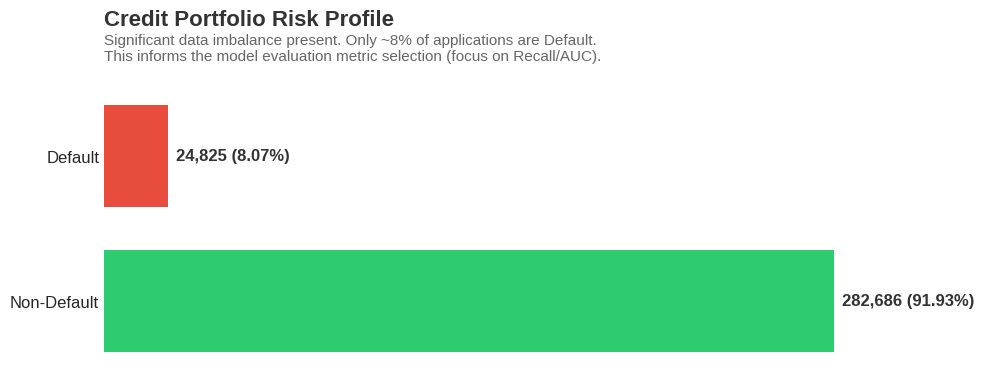

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#2ecc71', '#e74c3c'] 
bars = ax.barh(['Non-Default', 'Default'], 
               target_counts.values, 
               color=colors, 
               height=0.7) 

ax.grid(False) 
ax.set_xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0, 1.25, 'Credit Portfolio Risk Profile', 
        transform=ax.transAxes, fontsize=16, fontweight='bold', color='#333333')

ax.text(0, 1.12, 'Significant data imbalance present. Only ~8% of applications are Default.\nThis informs the model evaluation metric selection (focus on Recall/AUC).', 
        transform=ax.transAxes, fontsize=11, color='#666666')

total = sum(target_counts.values)
for bar, count in zip(bars, target_counts.values):
    pct = (count / total) * 100
    ax.text(bar.get_width() + (total * 0.01), bar.get_y() + bar.get_height()/2, 
            f'{count:,.0f} ({pct:.2f}%)', 
            va='center', fontsize=12, fontweight='bold', color='#333333')

plt.tight_layout()
plt.savefig('clean_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Missing Values Audit

Identifying columns with high missing rates in the application data.

In [46]:
def missing_report(df, top_n=30):
    miss_rate = df.isna().mean()
    report = pd.DataFrame({
        "missing_count": df.isna().sum(),
        "missing_rate": miss_rate,
        "missing_pct": (miss_rate * 100).round(2),
        "dtype": df.dtypes.astype(str)
    })
    report = report[report["missing_rate"] > 0].sort_values("missing_rate", ascending=False)
    return report.head(top_n)

miss_report = missing_report(app_train, top_n=40)
print("=" * 60)
print("TOP 40 COLUMNS WITH MISSING VALUES (app_train)")
print("=" * 60)
display(miss_report)

# Save report
miss_report.to_csv(OUTPUT_DIR / "missing_report_app_train.csv")
print(f"\nSaved: {OUTPUT_DIR / 'missing_report_app_train.csv'}")

TOP 40 COLUMNS WITH MISSING VALUES (app_train)


,missing_count,missing_rate,missing_pct,dtype
COMMONAREA_MEDI,214865,0.6987,69.8700,float64
COMMONAREA_MODE,214865,0.6987,69.8700,float64
COMMONAREA_AVG,214865,0.6987,69.8700,float64
NONLIVINGAPARTMENTS_MODE,213514,0.6943,69.4300,float64
NONLIVINGAPARTMENTS_MEDI,213514,0.6943,69.4300,float64
NONLIVINGAPARTMENTS_AVG,213514,0.6943,69.4300,float64
FONDKAPREMONT_MODE,210295,0.6839,68.3900,object
LIVINGAPARTMENTS_AVG,210199,0.6835,68.3500,float64
LIVINGAPARTMENTS_MEDI,210199,0.6835,68.3500,float64
LIVINGAPARTMENTS_MODE,210199,0.6835,68.3500,float64



Saved: outputs/missing_report_app_train.csv


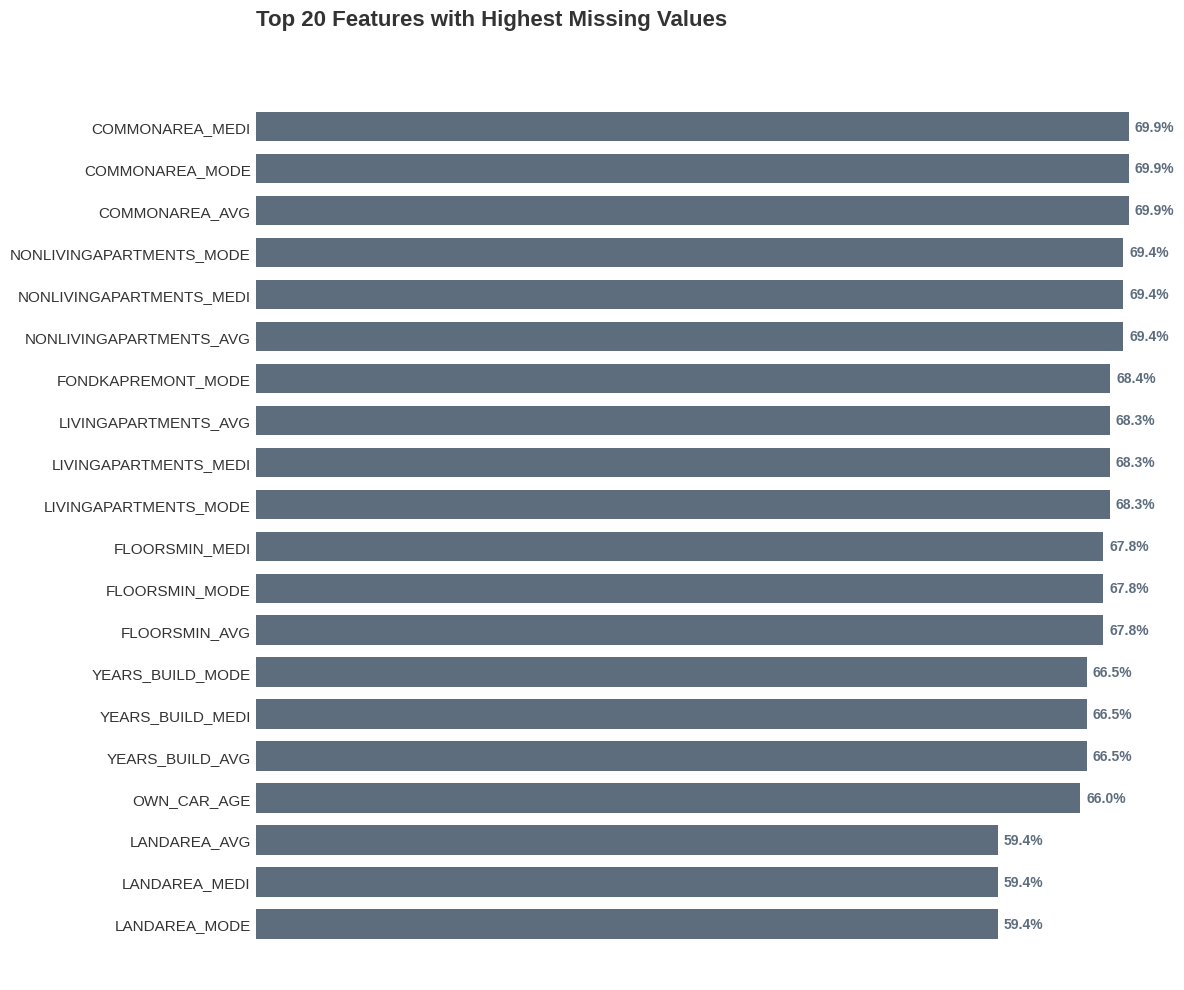


Saved: outputs/figures/missing_values_top20.png


In [47]:
top_missing = miss_report.head(20)

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_missing)), 
               top_missing['missing_pct'].values, 
               color='#5D6D7E', 
               height=0.7)

ax.set_yticks(range(len(top_missing)))
ax.set_yticklabels(top_missing.index, fontsize=11, color='#333333')
ax.invert_yaxis() 

ax.grid(False)
ax.set_xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0, 1.05, 'Top 20 Features with Highest Missing Values', 
        transform=ax.transAxes, fontsize=16, fontweight='bold', color='#333333')

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', 
            va='center', fontsize=10, fontweight='bold', color='#5D6D7E')

plt.tight_layout()
plt.savefig(FIG_DIR / 'missing_values_top20.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSaved: {FIG_DIR / 'missing_values_top20.png'}")

## 6. Memory Usage Analysis

Understanding the memory footprint of each table.

In [48]:
# MEMORY USAGE
mem_data = []
for name, df in [
    ("app_train", app_train), ("app_test", app_test),
    ("bureau", bureau), ("bureau_balance", bureau_balance),
    ("previous_app", previous_app), ("pos_cash", pos_cash),
    ("installments", installments), ("credit_card", credit_card),
]:
    mem_data.append({
        "table": name,
        "rows": len(df),
        "cols": df.shape[1],
        "mem_mb": memory_usage_mb(df)
    })

mem_df = pd.DataFrame(mem_data).sort_values("mem_mb", ascending=False)
mem_df["mem_mb"] = mem_df["mem_mb"].round(2)

print("=" * 60)
print("MEMORY USAGE BY TABLE")
print("=" * 60)
display(mem_df)

total_mem = mem_df['mem_mb'].sum()
print(f"\nTotal Memory Usage: {total_mem:,.2f} MB ({total_mem/1024:.2f} GB)")

mem_df.to_csv(OUTPUT_DIR / "memory_usage_tables.csv", index=False)
print(f"Saved: {OUTPUT_DIR / 'memory_usage_tables.csv'}")

MEMORY USAGE BY TABLE


,table,rows,cols,mem_mb
3,bureau_balance,27299925,3,"1,926.6100"
4,previous_app,1670214,37,"1,900.6300"
5,pos_cash,10001358,8,"1,137.2500"
7,credit_card,3840312,23,875.6900
6,installments,13605401,8,830.4100
0,app_train,307511,122,536.6900
2,bureau,1716428,17,512.1100
1,app_test,48744,121,84.7400



Total Memory Usage: 7,804.13 MB (7.62 GB)
Saved: outputs/memory_usage_tables.csv


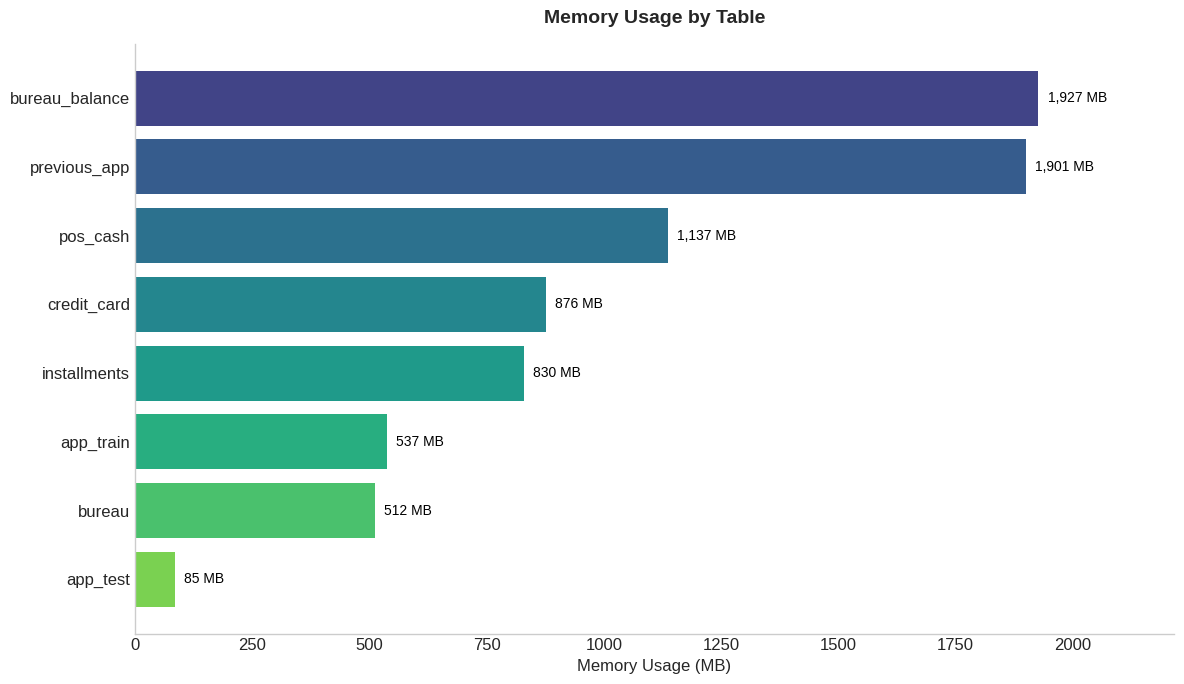


Saved: outputs/figures/memory_usage.png


In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(mem_df)))
bars = ax.barh(mem_df['table'], mem_df['mem_mb'], color=colors)

ax.set_xlabel('Memory Usage (MB)', fontsize=12)
ax.set_title('Memory Usage by Table', fontsize=14, fontweight='bold', pad=15)
ax.invert_yaxis() 
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

max_mem = mem_df['mem_mb'].max()
ax.set_xlim(0, max_mem * 1.15)

for bar, mem in zip(bars, mem_df['mem_mb'].values):
    ax.text(bar.get_width() + (max_mem * 0.01),     
            bar.get_y() + bar.get_height()/2,        
            f'{mem:,.0f} MB',
            va='center', fontsize=10, color='black') 

plt.tight_layout()
plt.savefig(FIG_DIR / 'memory_usage.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nSaved: {FIG_DIR / 'memory_usage.png'}")

## 6.1 Feature Type Analysis

Identifying numeric vs categorical features.

In [50]:
# FEATURE TYPE ANALYSIS
id_cols = ["SK_ID_CURR"]
label_col = ["TARGET"]

feature_cols = [c for c in app_train.columns if c not in id_cols + label_col]
numeric_cols = app_train[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = app_train[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

print("=" * 50)
print("FEATURE TYPE SUMMARY (app_train)")
print("=" * 50)
print(f"Total features: {len(feature_cols)}")
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols}")

FEATURE TYPE SUMMARY (app_train)
Total features: 120
Numeric features: 104
Categorical features: 16

Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


## 6.2 Deep Dive: Demographic & Financial Analysis

Understanding the profile of the borrowers: Who are they and what is their financial status?

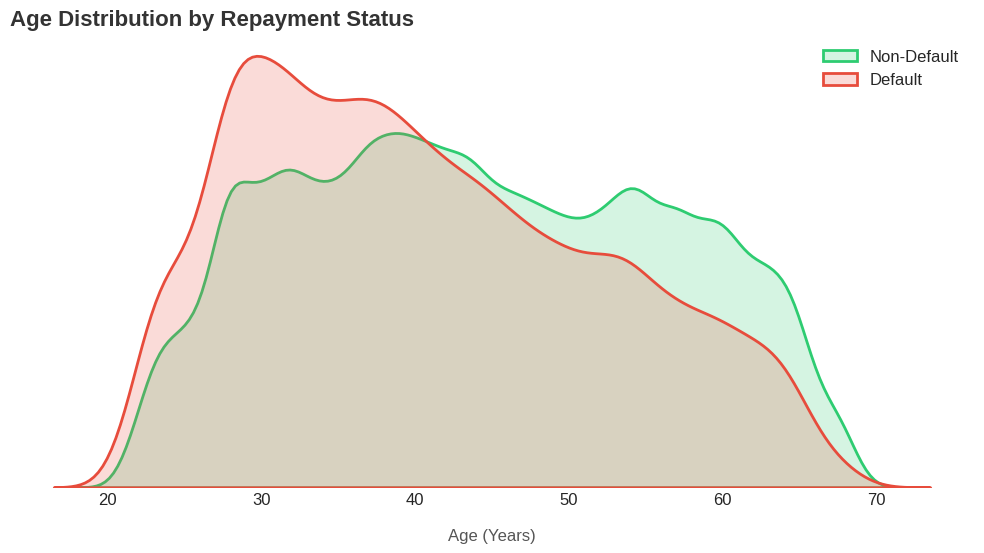

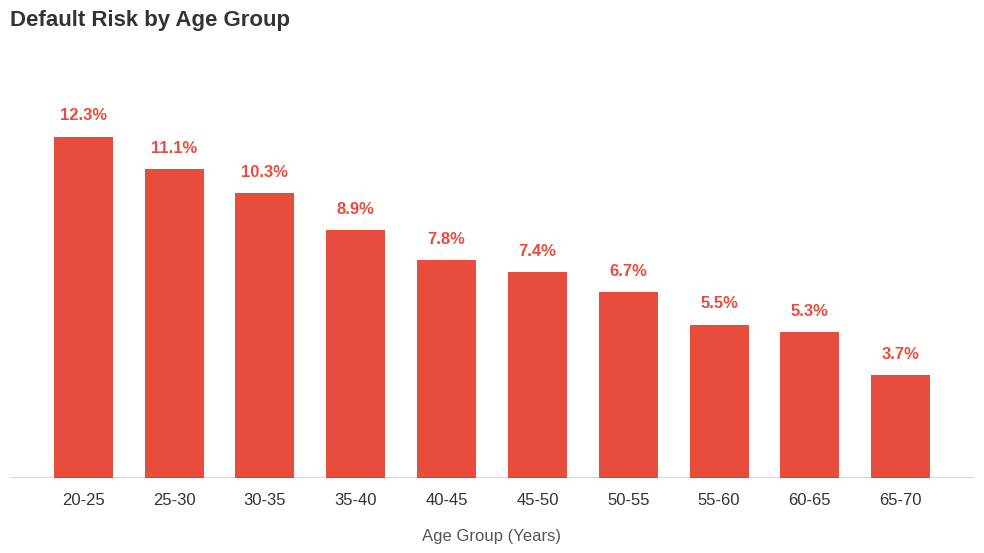


Saved images to outputs/figures


In [53]:
app_train['AGE_YEARS'] = abs(app_train['DAYS_BIRTH']) / 365

# VISUALIZATION 1: AGE DISTRIBUTION (KDE)
fig1, ax1 = plt.subplots(figsize=(10, 6))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AGE_YEARS'], 
            label='Non-Default', color='#2ecc71', fill=True, alpha=0.2, linewidth=2, ax=ax1)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AGE_YEARS'], 
            label='Default', color='#e74c3c', fill=True, alpha=0.2, linewidth=2, ax=ax1)

ax1.grid(False)
ax1.set_yticks([])
ax1.set_ylabel('')
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.text(0, 1.02, 'Age Distribution by Repayment Status', 
         transform=ax1.transAxes, fontsize=16, fontweight='bold', color='#333333')
ax1.set_xlabel('Age (Years)', fontsize=12, color='#555555', labelpad=15)
ax1.legend(frameon=False, fontsize=12, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig(FIG_DIR / 'age_distribution_kde.png', dpi=150, bbox_inches='tight')
plt.show()


# VISUALIZATION 2: DEFAULT RISK BY AGE GROUP
fig2, ax2 = plt.subplots(figsize=(10, 6))

bins = np.linspace(20, 70, 11)
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
age_groups = app_train.groupby(pd.cut(app_train['AGE_YEARS'], bins=bins))['TARGET'].mean() * 100

bars = ax2.bar(labels, age_groups.values, color='#e74c3c', width=0.65)

ax2.set_ylim(0, age_groups.max() * 1.3) 
ax2.grid(False)
ax2.set_yticks([])
ax2.set_ylabel('')
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.text(0, 1.02, 'Default Risk by Age Group', 
         transform=ax2.transAxes, fontsize=16, fontweight='bold', color='#333333')

ax2.set_xlabel('Age Group (Years)', fontsize=12, color='#555555', labelpad=15)
ax2.tick_params(axis='x', colors='#333333', labelsize=12, pad=10)
ax2.axhline(0, color='#333333', linewidth=1) 

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='#e74c3c')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'age_default_risk.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved images to {FIG_DIR}")

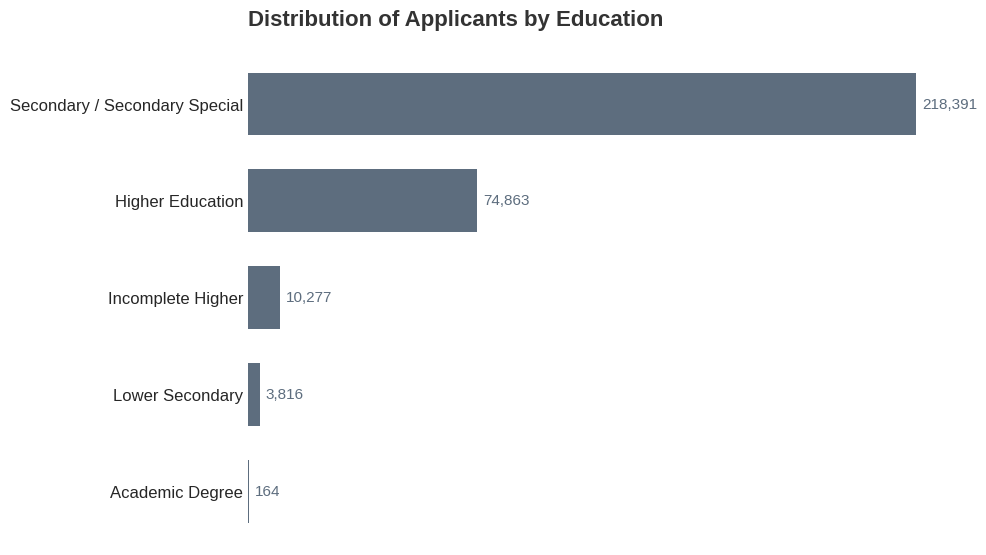

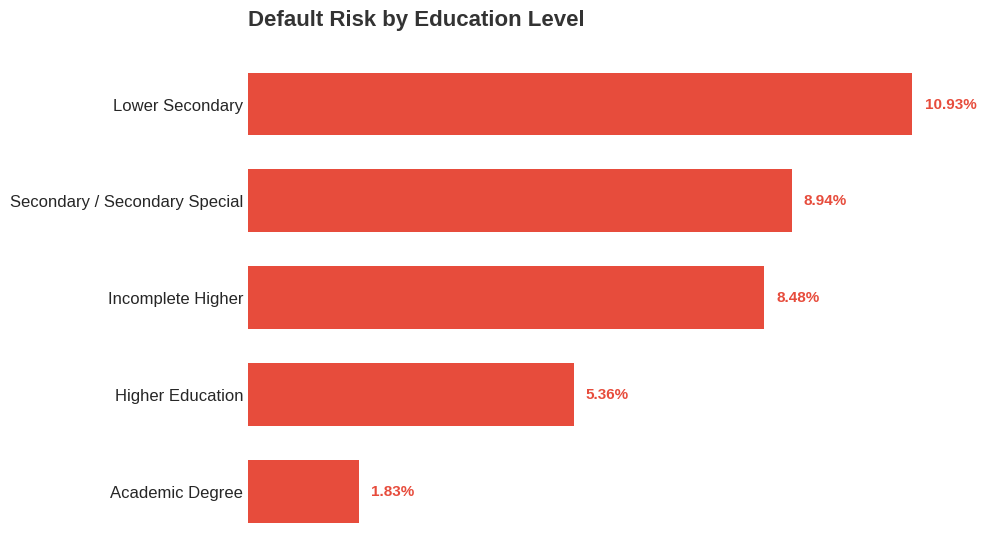


Saved images to outputs/figures


In [54]:
# VISUALIZATION 3: EDUCATION DISTRIBUTION
fig1, ax1 = plt.subplots(figsize=(10, 6))

edu_counts = app_train['NAME_EDUCATION_TYPE'].value_counts()
clean_labels = [label.title() for label in edu_counts.index]

bars = ax1.barh(clean_labels, edu_counts.values, color='#5D6D7E', height=0.65)
ax1.invert_yaxis() 
ax1.grid(False)
ax1.set_xticks([]) 
ax1.set_ylabel('')
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.text(0, 1.05, 'Distribution of Applicants by Education', 
         transform=ax1.transAxes, fontsize=16, fontweight='bold', color='#333333')

for bar in bars:
    width = bar.get_width()
    ax1.text(width + 2000, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', 
             va='center', fontsize=11, color='#5D6D7E')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'education_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# VISUALIZATION 4: DEFAULT RISK BY EDUCATION
fig2, ax2 = plt.subplots(figsize=(10, 6))

edu_default = app_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().sort_values(ascending=False)
clean_labels_risk = [label.title() for label in edu_default.index]

bars2 = ax2.barh(clean_labels_risk, edu_default.values * 100, color='#e74c3c', height=0.65)
ax2.invert_yaxis() 
ax2.grid(False)
ax2.set_xticks([])
ax2.set_ylabel('')
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.text(0, 1.05, 'Default Risk by Education Level', 
         transform=ax2.transAxes, fontsize=16, fontweight='bold', color='#333333')

for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}%', 
             va='center', fontsize=11, fontweight='bold', color='#e74c3c')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'education_risk.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved images to {FIG_DIR}")

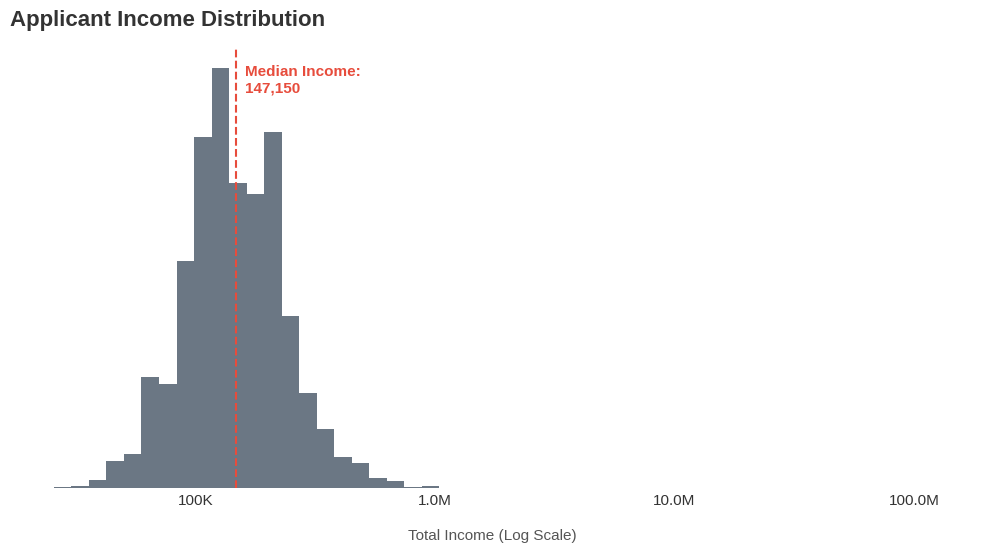

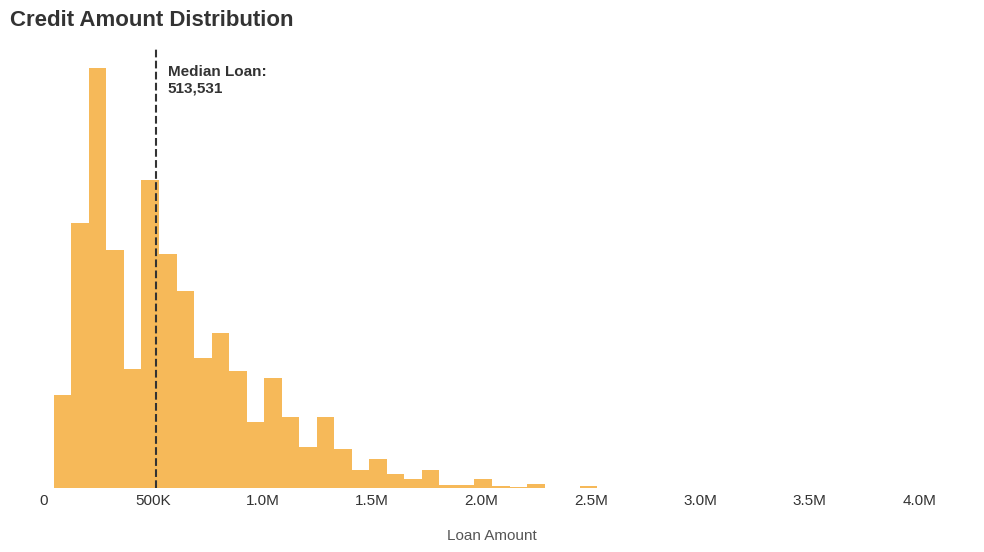

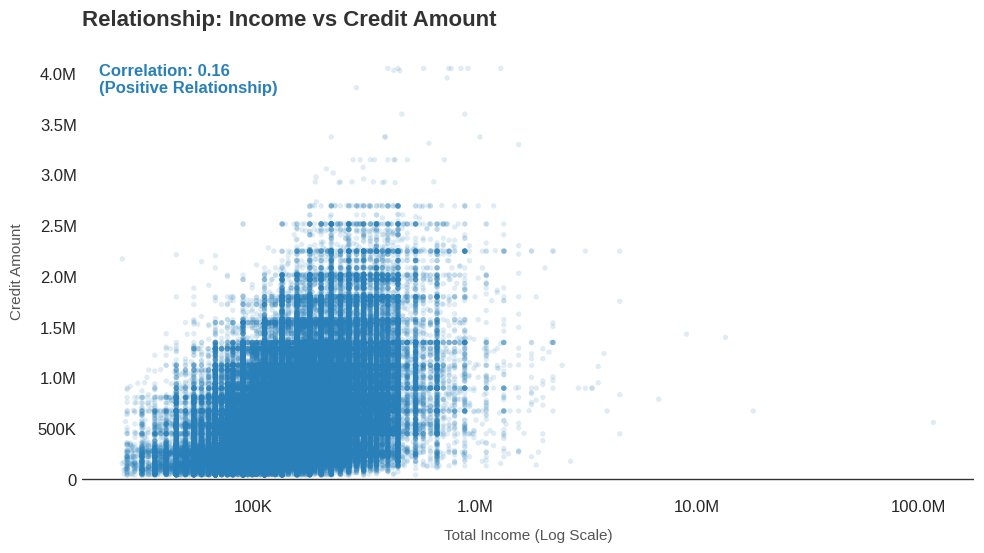


Saved images to outputs/figures


In [59]:
def currency_formatter(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

# VISUALIZATION 5: INCOME DISTRIBUTION
fig1, ax1 = plt.subplots(figsize=(10, 6))
sns.histplot(app_train['AMT_INCOME_TOTAL'], bins=50, log_scale=True, 
             color='#2c3e50', alpha=0.7, edgecolor=None, ax=ax1) 

median_income = app_train['AMT_INCOME_TOTAL'].median()
ax1.axvline(median_income, color='#e74c3c', linestyle='--', linewidth=1.5)
ax1.text(median_income * 1.1, ax1.get_ylim()[1] * 0.9, 
         f'Median Income:\n{median_income:,.0f}', 
         color='#e74c3c', fontweight='bold', fontsize=11)

ax1.grid(False)
ax1.set_ylabel('')
ax1.set_yticks([]) 
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.text(0, 1.05, 'Applicant Income Distribution', 
         transform=ax1.transAxes, fontsize=16, fontweight='bold', color='#333333')
ax1.set_xlabel('Total Income (Log Scale)', fontsize=11, color='#555555', labelpad=15)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))
ax1.tick_params(axis='x', colors='#333333', labelsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'financial_income_dist.png', dpi=150, bbox_inches='tight')
plt.show()

# VISUALIZATION 6: CREDIT AMOUNT DISTRIBUTION
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.histplot(app_train['AMT_CREDIT'], bins=50, 
             color='#f39c12', alpha=0.7, edgecolor=None, ax=ax2) 

median_credit = app_train['AMT_CREDIT'].median()
ax2.axvline(median_credit, color='#333333', linestyle='--', linewidth=1.5)
ax2.text(median_credit * 1.1, ax2.get_ylim()[1] * 0.9, 
         f'Median Loan:\n{median_credit:,.0f}', 
         color='#333333', fontweight='bold', fontsize=11)

ax2.grid(False)
ax2.set_ylabel('')
ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.text(0, 1.05, 'Credit Amount Distribution', 
         transform=ax2.transAxes, fontsize=16, fontweight='bold', color='#333333')
ax2.set_xlabel('Loan Amount', fontsize=11, color='#555555', labelpad=15)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))
ax2.tick_params(axis='x', colors='#333333', labelsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'financial_credit_dist.png', dpi=150, bbox_inches='tight')
plt.show()

# VISUALIZATION 7: INCOME vs CREDIT (SCATTER)
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.scatter(app_train['AMT_INCOME_TOTAL'], app_train['AMT_CREDIT'], 
            alpha=0.15, s=15, color='#2980b9', edgecolors='none')

ax3.set_xscale('log') 
corr = app_train['AMT_INCOME_TOTAL'].corr(app_train['AMT_CREDIT'])

ax3.grid(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.axhline(0, color='#333333', linewidth=1)
ax3.axvline(0, color='#333333', linewidth=1)

ax3.text(0, 1.05, 'Relationship: Income vs Credit Amount', 
         transform=ax3.transAxes, fontsize=16, fontweight='bold', color='#333333')

ax3.text(0.02, 0.9, f'Correlation: {corr:.2f}\n(Positive Relationship)', 
         transform=ax3.transAxes, fontsize=12, fontweight='bold', 
         color='#2980b9', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax3.set_xlabel('Total Income (Log Scale)', fontsize=11, color='#555555', labelpad=10)
ax3.set_ylabel('Credit Amount', fontsize=11, color='#555555', labelpad=10)

ax3.xaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'financial_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved images to {FIG_DIR}")

Calculating correlations with TARGET...

Most Positive Correlations:
 FLAG_DOCUMENT_3               0.0443
REG_CITY_NOT_LIVE_CITY        0.0444
FLAG_EMP_PHONE                0.0460
REG_CITY_NOT_WORK_CITY        0.0510
DAYS_ID_PUBLISH               0.0515
DAYS_LAST_PHONE_CHANGE        0.0552
REGION_RATING_CLIENT          0.0589
REGION_RATING_CLIENT_W_CITY   0.0609
DAYS_BIRTH                    0.0782
TARGET                        1.0000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.1789
EXT_SOURCE_2                 -0.1605
EXT_SOURCE_1                 -0.1553
AGE_YEARS                    -0.0782
DAYS_EMPLOYED                -0.0449
FLOORSMAX_AVG                -0.0440
FLOORSMAX_MEDI               -0.0438
FLOORSMAX_MODE               -0.0432
AMT_GOODS_PRICE              -0.0396
REGION_POPULATION_RELATIVE   -0.0372
Name: TARGET, dtype: float64


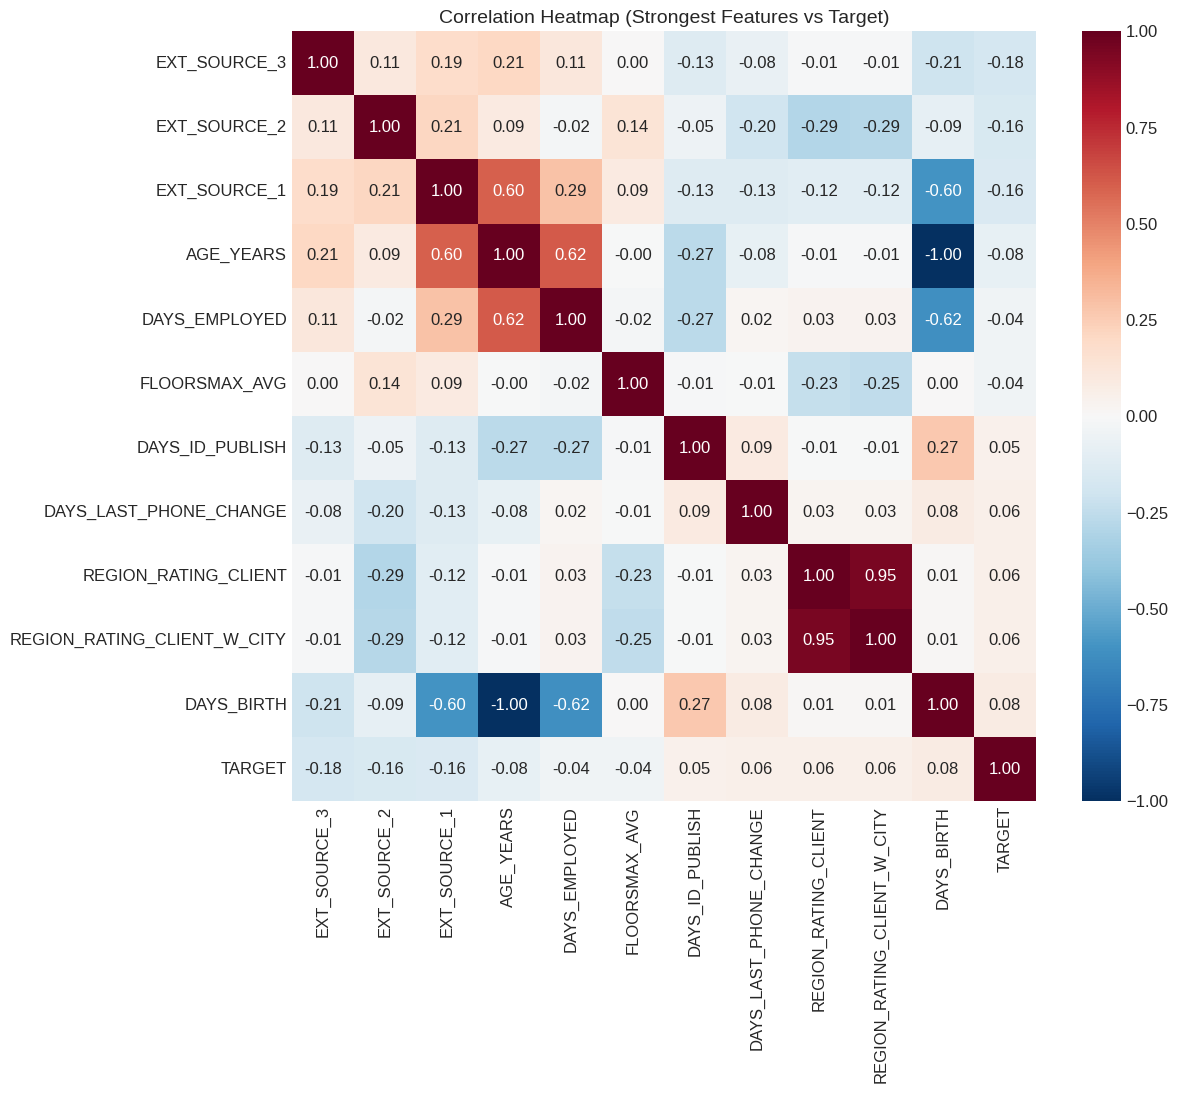

In [60]:
# 4. CORRELATION ANALYSIS
print("Calculating correlations with TARGET...")
numeric_df = app_train.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['TARGET'].sort_values()

print("\nMost Positive Correlations:\n", correlations.tail(10))
print("\nMost Negative Correlations:\n", correlations.head(10))

strong_features = correlations.head(6).index.tolist() + correlations.tail(6).index.tolist()
corr_matrix = numeric_df[strong_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, fmt='.2f', center=0)
plt.title('Correlation Heatmap (Strongest Features vs Target)', fontsize=14)
plt.savefig(FIG_DIR / 'correlation_heatmap.png', dpi=150)
plt.show()

---

# STAGE 2: Baseline Models

Building baseline models using only application data.

## 7. Train/Validation Split

In [61]:
ID_COL = "SK_ID_CURR"
TARGET_COL = "TARGET"

X = app_train.drop(columns=[TARGET_COL])
y = app_train[TARGET_COL].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Drop ID for modeling
X_train_m = X_train.drop(columns=[ID_COL])
X_valid_m = X_valid.drop(columns=[ID_COL])

# Get column types
num_cols = X_train_m.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_m.select_dtypes(exclude=[np.number]).columns.tolist()

print("=" * 50)
print("TRAIN/VALIDATION SPLIT")
print("=" * 50)
print(f"X_train: {X_train_m.shape}")
print(f"X_valid: {X_valid_m.shape}")
print(f"\nNumeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"\nDefault rate - Train: {y_train.mean():.4%}")
print(f"Default rate - Valid: {y_valid.mean():.4%}")

TRAIN/VALIDATION SPLIT
X_train: (246008, 122)
X_valid: (61503, 122)

Numeric columns: 105
Categorical columns: 17

Default rate - Train: 8.0729%
Default rate - Valid: 8.0728%


## 8. Baseline Logistic Regression

Training logistic regression on application data only.

In [62]:
print("Training Baseline Logistic Regression...")

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
], remainder="drop")

model_lr_base = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

model_lr_base.fit(X_train_m, y_train)
proba_lr_base = model_lr_base.predict_proba(X_valid_m)[:, 1]
auc_lr_base = roc_auc_score(y_valid, proba_lr_base)

print(f"\nBaseline LogReg ROC-AUC: {auc_lr_base:.5f}")

Training Baseline Logistic Regression...

Baseline LogReg ROC-AUC: 0.74979


## 9. Baseline Random Forest

In [63]:
print("Training Baseline Random Forest...")

numeric_pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer([
    ("num", numeric_pipe_rf, num_cols),
    ("cat", categorical_pipe_rf, cat_cols),
], remainder="drop")

model_rf_base = Pipeline([
    ("preprocess", preprocess_rf),
    ("model", RandomForestClassifier(
        n_estimators=300, min_samples_leaf=20,
        n_jobs=-1, random_state=42, class_weight="balanced_subsample"
    ))
])

model_rf_base.fit(X_train_m, y_train)
proba_rf_base = model_rf_base.predict_proba(X_valid_m)[:, 1]
auc_rf_base = roc_auc_score(y_valid, proba_rf_base)

print(f"\nBaseline RandomForest ROC-AUC: {auc_rf_base:.5f}")

Training Baseline Random Forest...

Baseline RandomForest ROC-AUC: 0.74611


In [64]:
# BASELINE COMPARISON
baseline_results = pd.DataFrame([
    {"model": "Logistic Regression (baseline)", "roc_auc": auc_lr_base},
    {"model": "Random Forest (baseline)", "roc_auc": auc_rf_base},
]).sort_values("roc_auc", ascending=False)

print("=" * 50)
print("BASELINE MODEL COMPARISON")
print("=" * 50)
display(baseline_results)

baseline_results.to_csv(OUTPUT_DIR / "baseline_results.csv", index=False)
print(f"\nSaved: {OUTPUT_DIR / 'baseline_results.csv'}")

BASELINE MODEL COMPARISON


,model,roc_auc
0,Logistic Regression (baseline),0.7498
1,Random Forest (baseline),0.7461



Saved: outputs/baseline_results.csv


---

# STAGE 3: Feature Engineering + Checkpoints

## Strategy for Relational Data (One-to-Many)
The history tables (Bureau, Installments, etc.) contain multiple rows for a single current applicant (`SK_ID_CURR`).
**CRITICAL**: We cannot simply merge these tables using a left join, as this would cause row duplication (1-to-many explosion) and ruin the modeling dataset.

**Solution**: We perform **Feature Aggregation** (Mean, Max, Sum, Count, etc.) grouped by `SK_ID_CURR` to summarize the history into a single row per customer before merging it into the main training set.

## 10. Installments Feature Engineering

Creating payment behavior features:
- `PAYMENT_DELAY`: Days between scheduled and actual payment
- `AMT_DIFF`: Difference between paid and scheduled amount
- `LATE_FLAG`: Binary indicator for late payments

In [65]:
print("Creating installments features...")

inst = installments.copy()

# Create derived features
inst["PAYMENT_DELAY"] = inst["DAYS_ENTRY_PAYMENT"] - inst["DAYS_INSTALMENT"]
inst["AMT_DIFF"] = inst["AMT_PAYMENT"] - inst["AMT_INSTALMENT"]
inst["LATE_FLAG"] = (inst["PAYMENT_DELAY"] > 0).astype(int)

print("\nDerived features summary:")
print(inst[["PAYMENT_DELAY", "AMT_DIFF", "LATE_FLAG"]].describe())

Creating installments features...

Derived features summary:
        PAYMENT_DELAY        AMT_DIFF       LATE_FLAG
count 13,602,496.0000 13,602,496.0000 13,605,401.0000
mean          -8.7874        187.1538          0.0843
std           25.5399     19,106.7321          0.2778
min       -3,189.0000 -2,424,726.4050          0.0000
25%          -14.0000          0.0000          0.0000
50%           -6.0000          0.0000          0.0000
75%            0.0000          0.0000          0.0000
max        2,884.0000  2,630,908.9350          1.0000


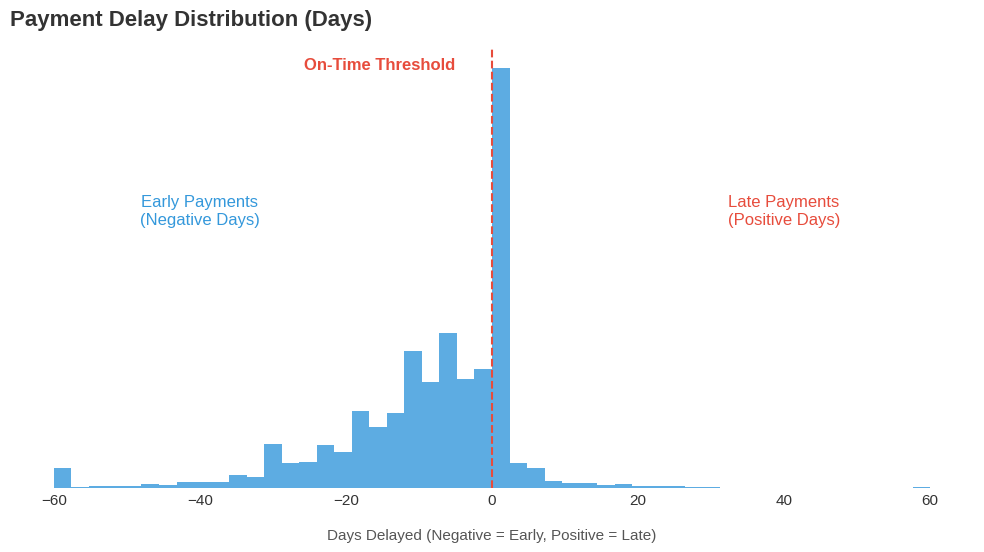

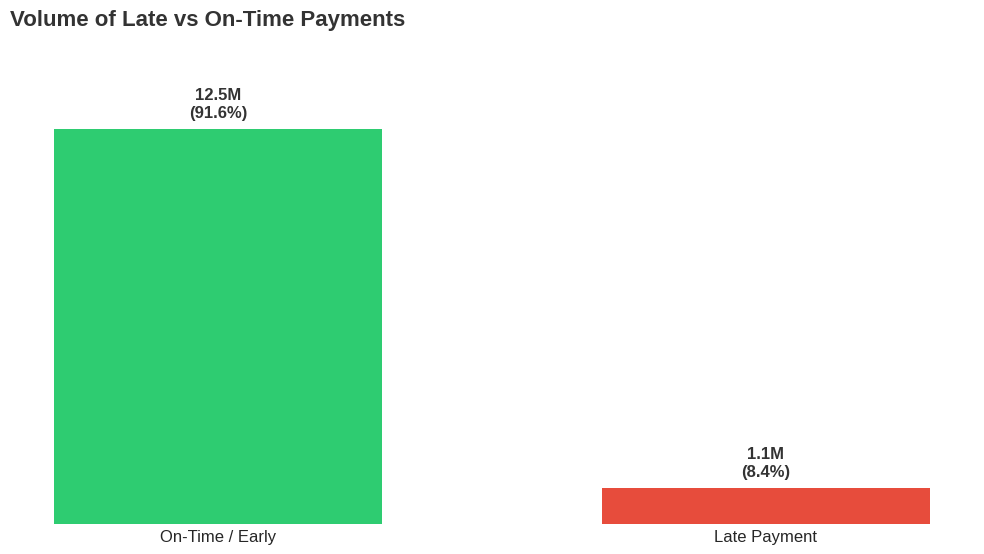


Saved images to outputs/figures


In [68]:
def number_formatter(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

# VISUALIZATION 8: PAYMENT DELAY BEHAVIOR
fig1, ax1 = plt.subplots(figsize=(10, 6))

delay_sample = inst["PAYMENT_DELAY"].dropna().sample(min(100000, len(inst)), random_state=42)
clipped_data = delay_sample.clip(-60, 60) 

ax1.hist(clipped_data, bins=50, color='#3498db', edgecolor=None, alpha=0.8)
ax1.axvline(x=0, color='#e74c3c', linestyle='--', linewidth=1.5)

ymax = ax1.get_ylim()[1]
ax1.text(-5, ymax * 0.95, 'On-Time Threshold', color='#e74c3c', ha='right', fontweight='bold')
ax1.text(-40, ymax * 0.6, 'Early Payments\n(Negative Days)', color='#3498db', ha='center')
ax1.text(40, ymax * 0.6, 'Late Payments\n(Positive Days)', color='#e74c3c', ha='center')

ax1.grid(False)
ax1.set_ylabel('')
ax1.set_yticks([]) 
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.text(0, 1.05, 'Payment Delay Distribution (Days)', 
         transform=ax1.transAxes, fontsize=16, fontweight='bold', color='#333333')
ax1.set_xlabel('Days Delayed (Negative = Early, Positive = Late)', fontsize=11, color='#555555', labelpad=15)
ax1.tick_params(axis='x', colors='#333333', labelsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'payment_delay_dist.png', dpi=150, bbox_inches='tight')
plt.show()


# VISUALIZATION 9: LATE vs ON-TIME VOLUME
fig2, ax2 = plt.subplots(figsize=(10, 6))


late_counts = inst["LATE_FLAG"].value_counts().sort_index()
labels = ['On-Time / Early', 'Late Payment']
colors = ['#2ecc71', '#e74c3c']


bars = ax2.bar(labels, late_counts.values, color=colors, width=0.6)
ax2.grid(False)
ax2.set_ylabel('')
ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.text(0, 1.05, 'Volume of Late vs On-Time Payments', 
         transform=ax2.transAxes, fontsize=16, fontweight='bold', color='#333333')

total = sum(late_counts.values)
for bar in bars:
    height = bar.get_height()
    pct = (height / total) * 100
    
    formatted_num = number_formatter(height, None)
    
    ax2.text(bar.get_x() + bar.get_width()/2., height + (total*0.02),
             f'{formatted_num}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')


ax2.set_ylim(0, total * 1.1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'payment_late_counts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved images to {FIG_DIR}")

In [ ]:
# AGGREGATE INSTALLMENTS PER CUSTOMER
group_key = "SK_ID_CURR"
prefix = "inst_"

inst_cnt = add_count(inst[[group_key]], group_key, prefix)

# Numeric aggregations
inst_num = inst[[group_key, "NUM_INSTALMENT_VERSION", "NUM_INSTALMENT_NUMBER",
                 "DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT",
                 "AMT_INSTALMENT", "AMT_PAYMENT",
                 "PAYMENT_DELAY", "AMT_DIFF", "LATE_FLAG"]]

inst_agg = agg_numeric(inst_num, group_key, prefix, agg_funcs=("mean", "max", "min", "sum"))
inst_feat = inst_cnt.merge(inst_agg, on=group_key, how="left")

print(f"inst_feat shape: {inst_feat.shape}")
display(inst_feat.head())

inst_feat shape: (339587, 38)


,SK_ID_CURR,inst_count,inst_NUM_INSTALMENT_VERSION_mean,inst_NUM_INSTALMENT_VERSION_max,inst_NUM_INSTALMENT_VERSION_min,inst_NUM_INSTALMENT_VERSION_sum,inst_NUM_INSTALMENT_NUMBER_mean,inst_NUM_INSTALMENT_NUMBER_max,inst_NUM_INSTALMENT_NUMBER_min,inst_NUM_INSTALMENT_NUMBER_sum,inst_DAYS_INSTALMENT_mean,inst_DAYS_INSTALMENT_max,inst_DAYS_INSTALMENT_min,inst_DAYS_INSTALMENT_sum,inst_DAYS_ENTRY_PAYMENT_mean,inst_DAYS_ENTRY_PAYMENT_max,inst_DAYS_ENTRY_PAYMENT_min,inst_DAYS_ENTRY_PAYMENT_sum,inst_AMT_INSTALMENT_mean,inst_AMT_INSTALMENT_max,inst_AMT_INSTALMENT_min,inst_AMT_INSTALMENT_sum,inst_AMT_PAYMENT_mean,inst_AMT_PAYMENT_max,inst_AMT_PAYMENT_min,inst_AMT_PAYMENT_sum,inst_PAYMENT_DELAY_mean,inst_PAYMENT_DELAY_max,inst_PAYMENT_DELAY_min,inst_PAYMENT_DELAY_sum,inst_AMT_DIFF_mean,inst_AMT_DIFF_max,inst_AMT_DIFF_min,inst_AMT_DIFF_sum,inst_LATE_FLAG_mean,inst_LATE_FLAG_max,inst_LATE_FLAG_min,inst_LATE_FLAG_sum
0,100001,7,1.1429,2.0000,1.0000,8.0000,2.7143,4,1,19,"-2,187.7143","-1,619.0000","-2,916.0000","-15,314.0000","-2,195.0000","-1,628.0000","-2,916.0000","-15,365.0000","5,885.1321","17,397.9000","3,951.0000","41,195.9250","5,885.1321","17,397.9000","3,951.0000","41,195.9250",-7.2857,11.0000,-36.0000,-51.0000,0.0000,0.0000,0.0000,0.0000,0.1429,1,0,1
1,100002,19,1.0526,2.0000,1.0000,20.0000,10.0000,19,1,190,-295.0000,-25.0000,-565.0000,"-5,605.0000",-315.4211,-49.0000,-587.0000,"-5,993.0000","11,559.2471","53,093.7450","9,251.7750","219,625.6950","11,559.2471","53,093.7450","9,251.7750","219,625.6950",-20.4211,-12.0000,-31.0000,-388.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
2,100003,25,1.0400,2.0000,1.0000,26.0000,5.0800,12,1,127,"-1,378.1600",-536.0000,"-2,310.0000","-34,454.0000","-1,385.3200",-544.0000,"-2,324.0000","-34,633.0000","64,754.5860","560,835.3600","6,662.9700","1,618,864.6500","64,754.5860","560,835.3600","6,662.9700","1,618,864.6500",-7.1600,-1.0000,-14.0000,-179.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
3,100004,3,1.3333,2.0000,1.0000,4.0000,2.0000,3,1,6,-754.0000,-724.0000,-784.0000,"-2,262.0000",-761.6667,-727.0000,-795.0000,"-2,285.0000","7,096.1550","10,573.9650","5,357.2500","21,288.4650","7,096.1550","10,573.9650","5,357.2500","21,288.4650",-7.6667,-3.0000,-11.0000,-23.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
4,100005,9,1.1111,2.0000,1.0000,10.0000,5.0000,9,1,45,-586.0000,-466.0000,-706.0000,"-5,274.0000",-609.5556,-470.0000,-736.0000,"-5,486.0000","6,240.2050","17,656.2450","4,813.2000","56,161.8450","6,240.2050","17,656.2450","4,813.2000","56,161.8450",-23.5556,1.0000,-37.0000,-212.0000,0.0000,0.0000,0.0000,0.0000,0.1111,1,0,1


In [ ]:
# MERGE INSTALLMENTS TO APPLICATION
print("Merging installments features...")
print(f"Before merge - train: {app_train.shape}, test: {app_test.shape}")

train_inst = app_train.merge(inst_feat, on='SK_ID_CURR', how='left')
test_inst = app_test.merge(inst_feat, on='SK_ID_CURR', how='left')

print(f"After merge - train: {train_inst.shape}, test: {test_inst.shape}")

# Integrity check
assert train_inst.shape[0] == app_train.shape[0], "Row count mismatch!"
assert train_inst['SK_ID_CURR'].duplicated().sum() == 0, "Duplicates found!"

if 'AGE_BIN' in train_inst.columns:
    train_inst['AGE_BIN'] = train_inst['AGE_BIN'].astype(str)
if 'AGE_BIN' in test_inst.columns:
    test_inst['AGE_BIN'] = test_inst['AGE_BIN'].astype(str)


# Save intermediate checkpoint
train_inst.to_parquet(CHK_TRAIN_INST, index=False)
test_inst.to_parquet(CHK_TEST_INST, index=False)
print(f"\nCheckpoints saved:")
print(f" - {CHK_TRAIN_INST}")
print(f" - {CHK_TEST_INST}")

# Cleanup
del installments, inst, inst_num, inst_cnt, inst_agg, inst_feat
gc.collect()
print("\nRAM cleanup done.")

Merging installments features...
Before merge - train: (307511, 124), test: (48744, 121)
After merge - train: (307511, 161), test: (48744, 158)

Checkpoints saved:
 - outputs/train_inst.parquet
 - outputs/test_inst.parquet

RAM cleanup done.


## 11. Bureau Feature Engineering

Creating credit history features from `bureau.csv`.

> **Note**: We will focus on `bureau.csv` aggregations. `bureau_balance` is extremely large (27M rows) and often causes OOM on standard environments. We prioritize high-value features from the main bureau table.

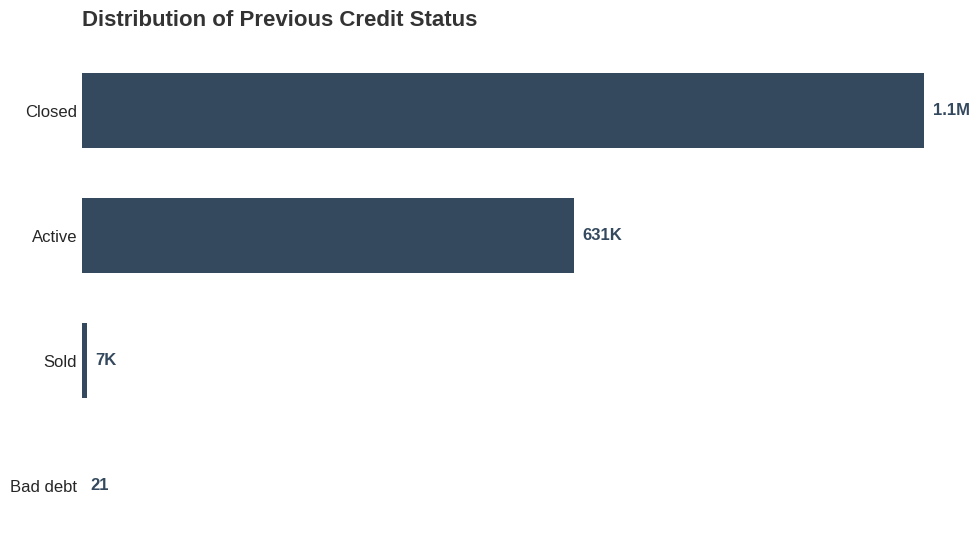

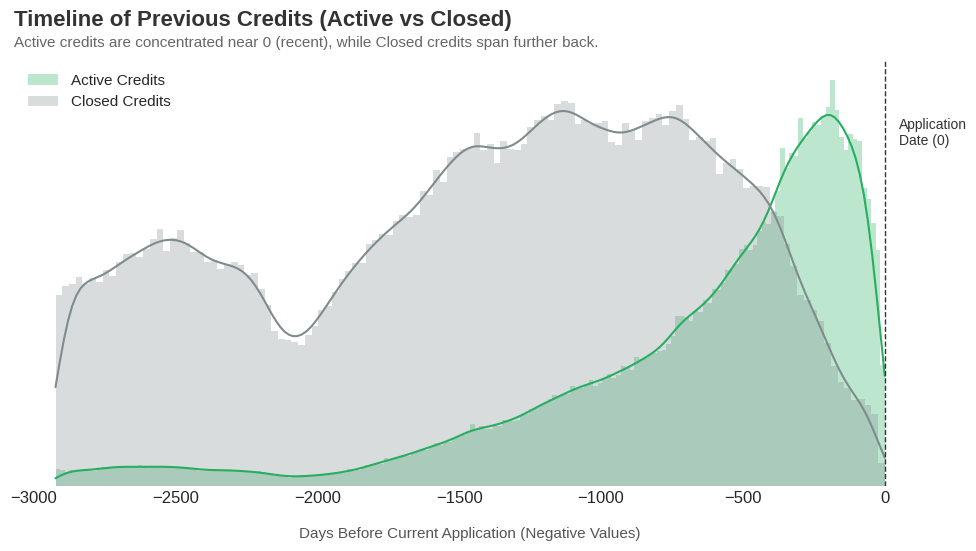


Saved images to outputs/figures


In [73]:
def number_formatter_bureau(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

# VISUALIZATION 10: CREDIT STATUS VOLUME
fig1, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.barh(status_counts.index, status_counts.values, color='#34495e', height=0.6)
ax1.invert_yaxis() 

ax1.grid(False)
ax1.set_xticks([]) 
ax1.set_ylabel('')
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.text(0, 1.05, 'Distribution of Previous Credit Status', 
         transform=ax1.transAxes, fontsize=16, fontweight='bold', color='#333333')

for bar in bars:
    width = bar.get_width()
    formatted_val = number_formatter_bureau(width, None)
    
    ax1.text(width + (status_counts.values.max() * 0.01), bar.get_y() + bar.get_height()/2, 
             f'{formatted_val}', 
             va='center', fontsize=12, fontweight='bold', color='#34495e')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'bureau_status_dist.png', dpi=150, bbox_inches='tight')
plt.show()

# VISUALIZATION 11: ACTIVE vs CLOSED TIMELINE
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.histplot(active_credit['DAYS_CREDIT'], color='#27ae60', label='Active Credits', 
             kde=True, element='step', alpha=0.3, ax=ax2, linewidth=0)
sns.histplot(closed_credit['DAYS_CREDIT'], color='#7f8c8d', label='Closed Credits', 
             kde=True, element='step', alpha=0.3, ax=ax2, linewidth=0)

ax2.grid(False)
ax2.set_ylabel('')
ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)

ax2.text(0, 1.08, 'Timeline of Previous Credits (Active vs Closed)', 
         transform=ax2.transAxes, fontsize=16, fontweight='bold', color='#333333')
ax2.text(0, 1.03, 'Active credits are concentrated near 0 (recent), while Closed credits span further back.', 
         transform=ax2.transAxes, fontsize=11, color='#666666')

ax2.set_xlabel('Days Before Current Application (Negative Values)', fontsize=11, color='#555555', labelpad=15)
ax2.legend(frameon=False, fontsize=11)

ax2.axvline(0, color='#333333', linestyle='--', linewidth=1)
ax2.text(50, ax2.get_ylim()[1]*0.8, 'Application\nDate (0)', color='#333333', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(FIG_DIR / 'bureau_days_credit.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved images to {FIG_DIR}")

In [ ]:
# BUREAU AGGREGATION
print("Aggregating bureau features...")

keep_cols = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
    'AMT_CREDIT_SUM_OVERDUE', 'CNT_CREDIT_PROLONG',
    'SK_ID_CURR'
]
bur_small = bureau[keep_cols].copy()

# Aggregation
bur_cnt = add_count(bur_small[['SK_ID_CURR']], 'SK_ID_CURR', 'bur_')
bur_agg = agg_numeric(bur_small, 'SK_ID_CURR', 'bur_', agg_funcs=('mean', 'max', 'min', 'sum'))
bureau_feat = bur_cnt.merge(bur_agg, on='SK_ID_CURR', how='left')

print(f"bureau_feat shape: {bureau_feat.shape}")

# Cleanup
del bureau, bur_small, bur_cnt, bur_agg
gc.collect()

Aggregating bureau features...
bureau_feat shape: (305811, 34)


21879

## 12. Save Checkpoints (Master)

Merging bureau features to create the final `master` dataset and saving it to parquet. This file will be loaded in Stage 4.

In [ ]:
# FINAL MERGE & SAVE
print("Merging bureau features to checkpoints...")

train_master = train_inst.merge(bureau_feat, on='SK_ID_CURR', how='left')
test_master = test_inst.merge(bureau_feat, on='SK_ID_CURR', how='left')

print(f"Final Train shape: {train_master.shape}")
print(f"Final Test shape: {test_master.shape}")

# Save Master Checkpoints
train_master.to_parquet(CHK_TRAIN_MASTER, index=False)
test_master.to_parquet(CHK_TEST_MASTER, index=False)

print("=" * 60)
print("STAGE 1 COMPLETE: Checkpoints Saved")
print("=" * 60)
print(f"Saved: {CHK_TRAIN_MASTER}")
print(f"Saved: {CHK_TEST_MASTER}")
print("\n>>> PLEASE RESTART THE KERNEL NOW TO FREE RAM <<<")
print(">>> THEN RUN STAGE 4 BELOW <<<")

Merging bureau features to checkpoints...
Final Train shape: (307511, 194)
Final Test shape: (48744, 191)
STAGE 1 COMPLETE: Checkpoints Saved
Saved: outputs/train_master.parquet
Saved: outputs/test_master.parquet

>>> PLEASE RESTART THE KERNEL NOW TO FREE RAM <<<
>>> THEN RUN STAGE 4 BELOW <<<


---

# STAGE 4: Final Modeling (Post-Restart)

**Pre-requisite**: Run Stage 1-3 first to build `train_master.parquet`, then **Restart Kernel**.

This stage uses significantly less RAM because it loads the featured dataset directly.

## 13. Load Master Checkpoints

In [5]:
if 'pd' not in dir():
    raise RuntimeError("Please run the 'Configuration & Setup' cells at the top of the notebook first (Stage 1, Step 1).")

print("Loading master checkpoints...")

if not CHK_TRAIN_MASTER.exists():
    raise FileNotFoundError("Checkpoint not found! Run Stage 1-3 first.")

train_master = pd.read_parquet(CHK_TRAIN_MASTER)
test_master = pd.read_parquet(CHK_TEST_MASTER)

print(f"Loaded Train: {train_master.shape}")
print(f"Loaded Test: {test_master.shape}")

X = train_master.drop(columns=["TARGET"])
y = train_master["TARGET"].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_m = X_train.drop(columns=["SK_ID_CURR"])
X_valid_m = X_valid.drop(columns=["SK_ID_CURR"])

num_cols = X_train_m.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_m.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Modeling features: {len(num_cols)} (num) + {len(cat_cols)} (cat) = {X_train_m.shape[1]}")

Loading master checkpoints...
Loaded Train: (307511, 194)
Loaded Test: (48744, 191)
Modeling features: 175 (num) + 17 (cat) = 192


## 14. Enhanced Models

Training two models on the full feature set:
1.  **Logistic Regression** (Linear baseline)
2.  **HistGradientBoosting** (Powerful tree-based model, handles NaNs natively)

In [7]:
# TRAIN MODELS
print("Training Logistic Regression...")
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess_lr = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
], remainder="drop")

model_lr = Pipeline([
    ("preprocess", preprocess_lr),
    ("model", LogisticRegression(max_iter=3000, solver="lbfgs"))
])
model_lr.fit(X_train_m, y_train)
proba_lr = model_lr.predict_proba(X_valid_m)[:, 1]
metric_lr = roc_auc_score(y_valid, proba_lr)
print(f"-> LogReg ROC-AUC: {metric_lr:.5f}")

print("\nTraining HistGradientBoosting...")
cat_pipe_hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess_hgb = ColumnTransformer([
    ("num", "passthrough", num_cols),  
    ("cat", cat_pipe_hgb, cat_cols)
])

model_hgb = Pipeline([
    ("preprocess", preprocess_hgb),
    ("model", HistGradientBoostingClassifier(
        max_iter=200, learning_rate=0.05, max_depth=6, random_state=42
    ))
])
model_hgb.fit(X_train_m, y_train)
proba_hgb = model_hgb.predict_proba(X_valid_m)[:, 1]
metric_hgb = roc_auc_score(y_valid, proba_hgb)
print(f"-> HGB ROC-AUC: {metric_hgb:.5f}")

Training Logistic Regression...
-> LogReg ROC-AUC: 0.76291

Training HistGradientBoosting...
-> HGB ROC-AUC: 0.77390


## 15. Evaluation & Visualization

Comparing models using ROC Curves and analyzing results.

Generating ROC curves...


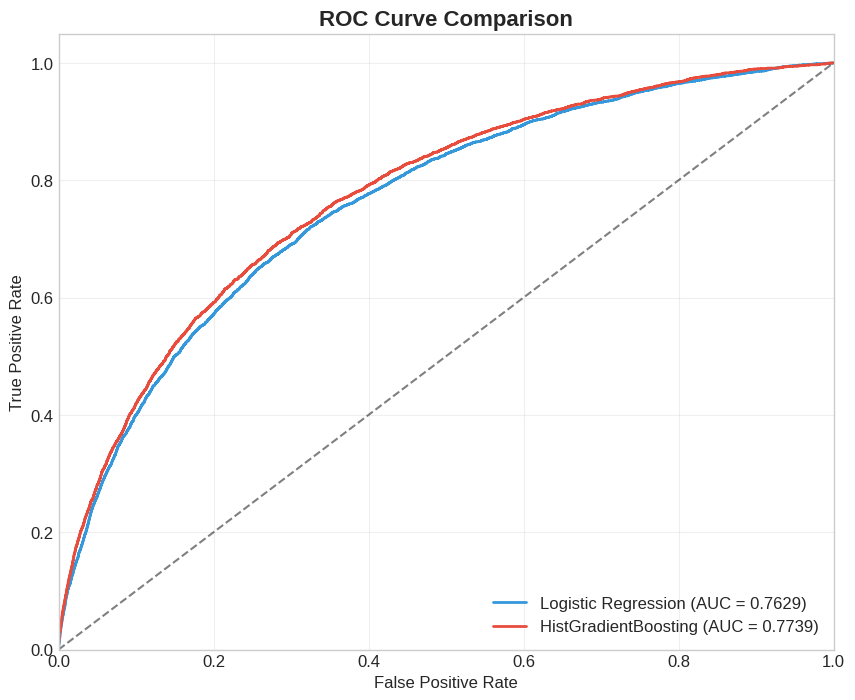

Saved: outputs/figures/final_roc_comparison.png


,model,auc
1,HistGradientBoosting,0.7739
0,Logistic Regression,0.7629



Notebook Execution Complete successfully.


In [8]:
# ROC CURVE COMPARISON
print("Generating ROC curves...")

fpr_lr, tpr_lr, _ = roc_curve(y_valid, proba_lr)
fpr_hgb, tpr_hgb, _ = roc_curve(y_valid, proba_hgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metric_lr:.4f})', color='#3498db', linewidth=2)
plt.plot(fpr_hgb, tpr_hgb, label=f'HistGradientBoosting (AUC = {metric_hgb:.4f})', color='#e74c3c', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / 'final_roc_comparison.png', dpi=150)
plt.show()
print(f"Saved: {FIG_DIR / 'final_roc_comparison.png'}")

# SAVE RESULTS
results = pd.DataFrame([
    {"model": "Logistic Regression", "auc": metric_lr},
    {"model": "HistGradientBoosting", "auc": metric_hgb}
]).sort_values("auc", ascending=False)

results.to_csv(OUTPUT_DIR / "final_model_results.csv", index=False)
display(results)
print("\nNotebook Execution Complete successfully.")

### 15.1 Feature Importance (HGB)

Understanding which features drive the model predictions using Permutation Importance.

Calculating feature importance (this may take a minute)...


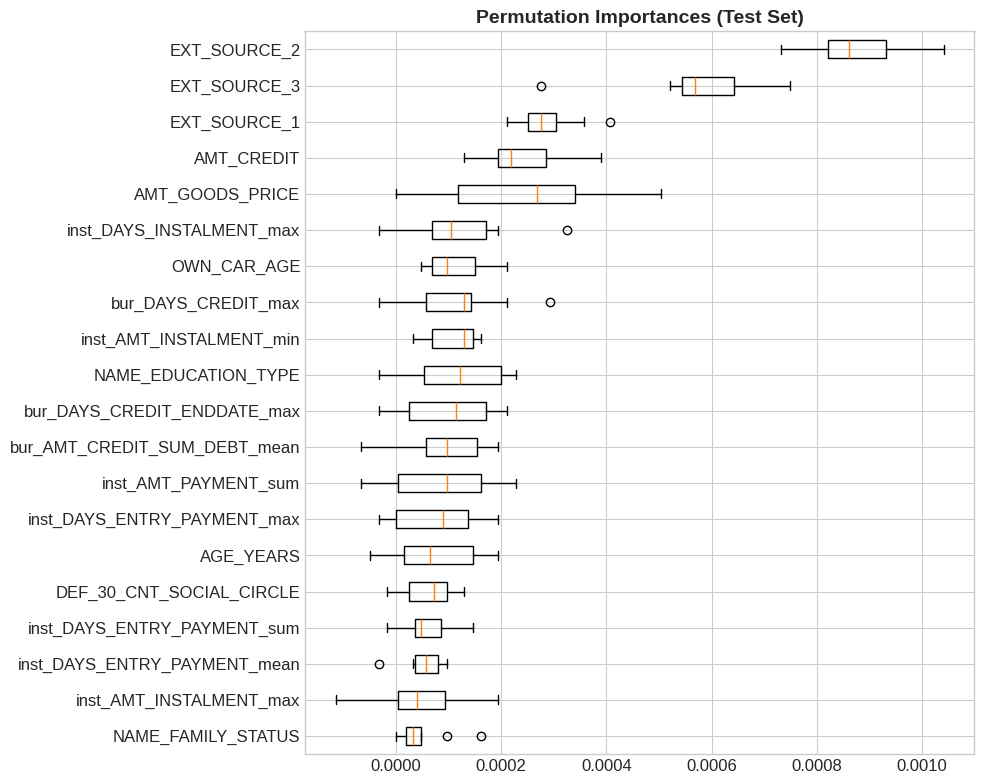

Saved: outputs/figures/feature_importance.png


In [ ]:
from sklearn.inspection import permutation_importance

print("Calculating feature importance (this may take a minute)...")
result = permutation_importance(
    model_hgb, X_valid_m, y_valid, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()
top_k = 20
top_idx = sorted_idx[-top_k:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(result.importances[top_idx].T, vert=False, labels=X_valid_m.columns[top_idx])
ax.set_title("Permutation Importances (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=150)
plt.show()

print(f"Saved: {FIG_DIR / 'feature_importance.png'}")

## 16. Business & Operational Analysis

Translating model performance into business impact. ROC-AUC is good for ranking, but for decision-making, we need to select a **cutoff threshold**.

### Trade-off Analysis
- **Low Threshold**: Catch more defaulters (higher Recall), but reject many good customers (lower Approval Rate).
- **High Threshold**: Approve more customers, but risk higher default rates (lower Precision).

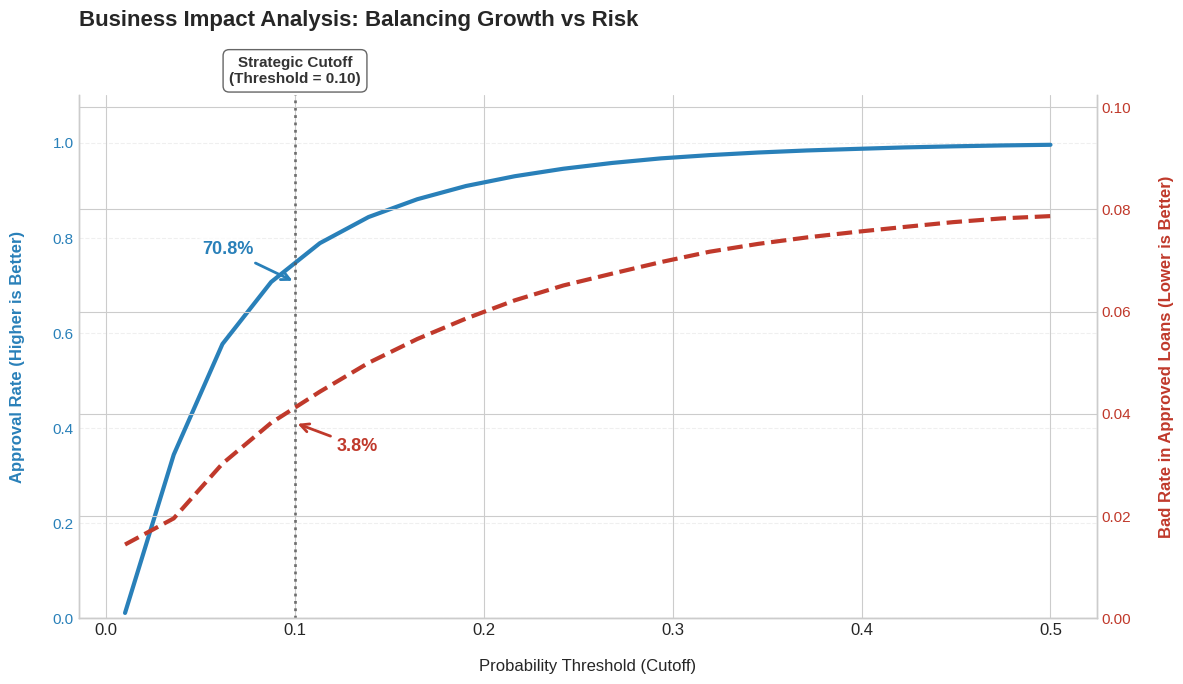

,Threshold,Approval_Rate,Bad_Rate_Approved,Recall_Defaults
0,0.0100,0.0113,0.0144,0.9980
3,0.0874,0.7076,0.0382,0.6649
6,0.1647,0.8816,0.0546,0.4032
9,0.2421,0.9458,0.0651,0.2371
12,0.3195,0.9744,0.0717,0.1343
15,0.3968,0.9875,0.0756,0.0753
18,0.4742,0.9948,0.0782,0.0359


In [9]:
def simulate_business_impact(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.50, 20)
    results = []
    
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        n_approve = (y_pred == 0).sum()
        n_total = len(y_true)
        approval_rate = n_approve / n_total
        defaults_in_approved = y_true[(y_pred == 0)].sum()
        bad_rate_approved = defaults_in_approved / n_approve if n_approve > 0 else 0
        
        results.append({
            'Threshold': t,
            'Approval_Rate': approval_rate,
            'Bad_Rate_Approved': bad_rate_approved,
            'Recall_Defaults': recall_score(y_true, y_pred) 
        })
    return pd.DataFrame(results)

biz_df = simulate_business_impact(y_valid, proba_hgb)

fig, ax1 = plt.subplots(figsize=(12, 7))
col_approve = '#2980b9'
col_risk = '#c0392b'

# Plot 1: Approval Rate
ax1.plot(biz_df['Threshold'], biz_df['Approval_Rate'], color=col_approve, linewidth=3)
ax1.set_xlabel('Probability Threshold (Cutoff)', fontsize=12, labelpad=15)
ax1.set_ylabel('Approval Rate (Higher is Better)', color=col_approve, fontsize=12, fontweight='bold', labelpad=20)
ax1.tick_params(axis='y', labelcolor=col_approve, labelsize=11)
ax1.set_ylim(0, 1.1)

# Plot 2: Bad Rate 
ax2 = ax1.twinx()
ax2.plot(biz_df['Threshold'], biz_df['Bad_Rate_Approved'], color=col_risk, linestyle='--', linewidth=3)
ax2.set_ylabel('Bad Rate in Approved Loans (Lower is Better)', color=col_risk, fontsize=12, fontweight='bold', labelpad=20)
ax2.tick_params(axis='y', labelcolor=col_risk, labelsize=11)
ax2.set_ylim(0, biz_df['Bad_Rate_Approved'].max() * 1.3)

# Strategic Point Logic
strategic_t = 0.10
row_loc = biz_df.iloc[(biz_df['Threshold'] - strategic_t).abs().argsort()[:1]]
val_appr = row_loc['Approval_Rate'].values[0]
val_risk = row_loc['Bad_Rate_Approved'].values[0]


ax1.axvline(strategic_t, color='#555555', linestyle=':', linewidth=2, alpha=0.8)

ax1.text(strategic_t, 1.12, 'Strategic Cutoff\n(Threshold = 0.10)', 
         color='#333333', fontsize=11, ha='center', va='bottom', fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#555555", alpha=0.9))

#Approval 
ax1.annotate(f'{val_appr:.1%}', xy=(strategic_t, val_appr), xytext=(-30, 20), 
             textcoords='offset points', color=col_approve, fontweight='bold', fontsize=13, ha='right',
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
             arrowprops=dict(arrowstyle="->", color=col_approve, linewidth=2, mutation_scale=15))

#Risk 
ax2.annotate(f'{val_risk:.1%}', xy=(strategic_t, val_risk), xytext=(30, -20), 
             textcoords='offset points', color=col_risk, fontweight='bold', fontsize=13, ha='left',
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
             arrowprops=dict(arrowstyle="->", color=col_risk, linewidth=2, mutation_scale=15))

ax1.grid(axis='y', linestyle='--', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.title('Business Impact Analysis: Balancing Growth vs Risk', fontsize=16, fontweight='bold', pad=50, loc='left')

plt.tight_layout()
plt.savefig(FIG_DIR / 'business_impact_tradeoff_final.png', dpi=150, bbox_inches='tight')
plt.show()

display(biz_df.round(4).iloc[::3])

### 16.1 Confusion Matrix at Optimal Threshold

Visualizing the Trade-off at **Threshold = 0.10** (Recommended for Safe Portfolio).

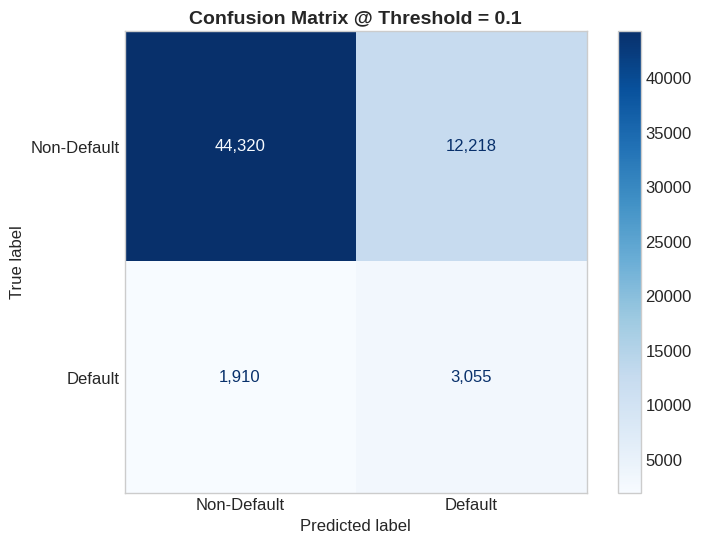

Saved: outputs/figures/confusion_matrix_opt.png
Correctly Approved (TN): 44,320
Missed Defaults (FN): 1,910 (Financial Loss)
False Alarms (FP): 12,218 (Lost Opportunity)
Caught Defaults (TP): 3,055


In [11]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

optimal_threshold = 0.10
y_pred_opt = (proba_hgb >= optimal_threshold).astype(int)

cm = confusion_matrix(y_valid, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default', 'Default'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format=',.0f')
plt.title(f'Confusion Matrix @ Threshold = {optimal_threshold}', fontsize=14, fontweight='bold')
plt.grid(False)
plt.savefig(FIG_DIR / 'confusion_matrix_opt.png', dpi=150)
plt.show()

print(f"Saved: {FIG_DIR / 'confusion_matrix_opt.png'}")

# Rates
tn, fp, fn, tp = cm.ravel()
print(f"Correctly Approved (TN): {tn:,}")
print(f"Missed Defaults (FN): {fn:,} (Financial Loss)")
print(f"False Alarms (FP): {fp:,} (Lost Opportunity)")
print(f"Caught Defaults (TP): {tp:,}")

In [ ]:
import pandas as pd

feat_imp_df = pd.DataFrame({
    'Feature': X_valid_m.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
})

feat_imp_df = feat_imp_df.sort_values(by='Importance_Mean', ascending=False).reset_index(drop=True)
feat_imp_df.to_csv(OUTPUT_DIR / 'feature_importance_hgb.csv', index=False)

print("Top 20 Features Driving the Model:")
display(feat_imp_df.head(20))
print(f"\nFull feature importance saved to: {OUTPUT_DIR / 'feature_importance_hgb.csv'}")

Top 20 Features Driving the Model:


,Feature,Importance_Mean,Importance_Std
0,EXT_SOURCE_2,0.0009,0.0001
1,EXT_SOURCE_3,0.0006,0.0001
2,EXT_SOURCE_1,0.0003,0.0001
3,AMT_CREDIT,0.0002,0.0001
4,AMT_GOODS_PRICE,0.0002,0.0002
5,inst_DAYS_INSTALMENT_max,0.0001,0.0001
6,bur_DAYS_CREDIT_max,0.0001,0.0001
7,OWN_CAR_AGE,0.0001,0.0001
8,inst_AMT_INSTALMENT_min,0.0001,0.0001
9,NAME_EDUCATION_TYPE,0.0001,0.0001



Full feature importance saved to: outputs/feature_importance_hgb.csv


### 16.2 Model Calibration Overview

Checking if the predicted probabilities reflect true risk. Ideally, points should fall on the diagonal dotted line.

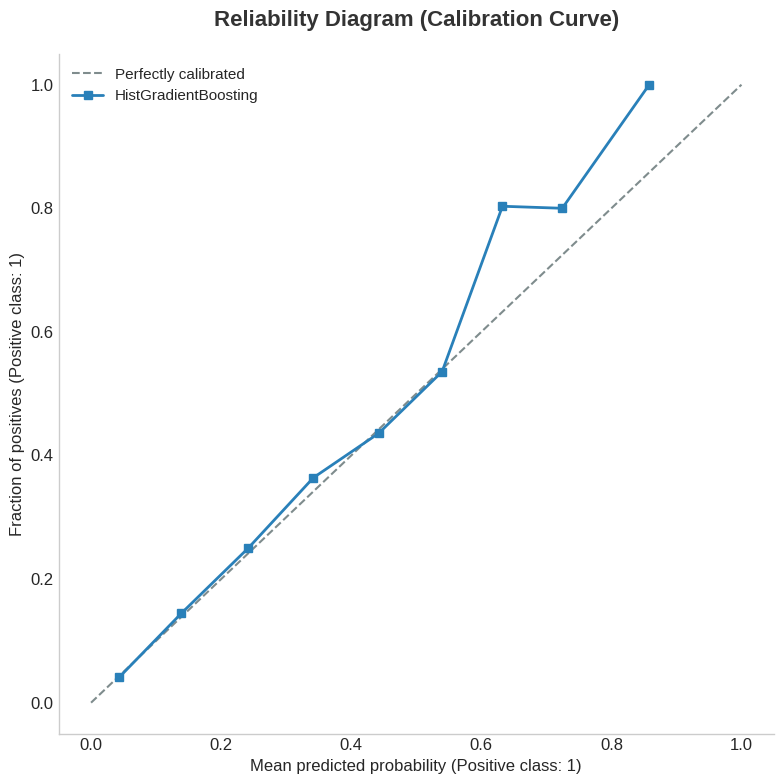

Saved: outputs/figures/calibration_curve.png


In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

disp = CalibrationDisplay.from_predictions(y_valid, proba_hgb, n_bins=10, name='HistGradientBoosting', ax=ax)
ax.lines[0].set_color('#7f8c8d') 
ax.lines[0].set_linestyle('--')
ax.lines[1].set_color('#2980b9')
ax.lines[1].set_marker('s') 
ax.lines[1].set_linewidth(2)

ax.set_title("Reliability Diagram (Calibration Curve)", fontsize=16, fontweight='bold', pad=20, color='#333333')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig(FIG_DIR / 'calibration_curve.png', dpi=150)
plt.show()

print(f"Saved: {FIG_DIR / 'calibration_curve.png'}")

### 16.3 Profitability Simulation

Estimating potential financial impact based on loan portfolio assumptions.
- **Avg Loan Size**: Derived from median `AMT_CREDIT`.
- **Interest Margin**: 10% (Revenue from Good Loan).
- **Loss Given Default (LGD)**: 70% (Loss from Bad Loan).

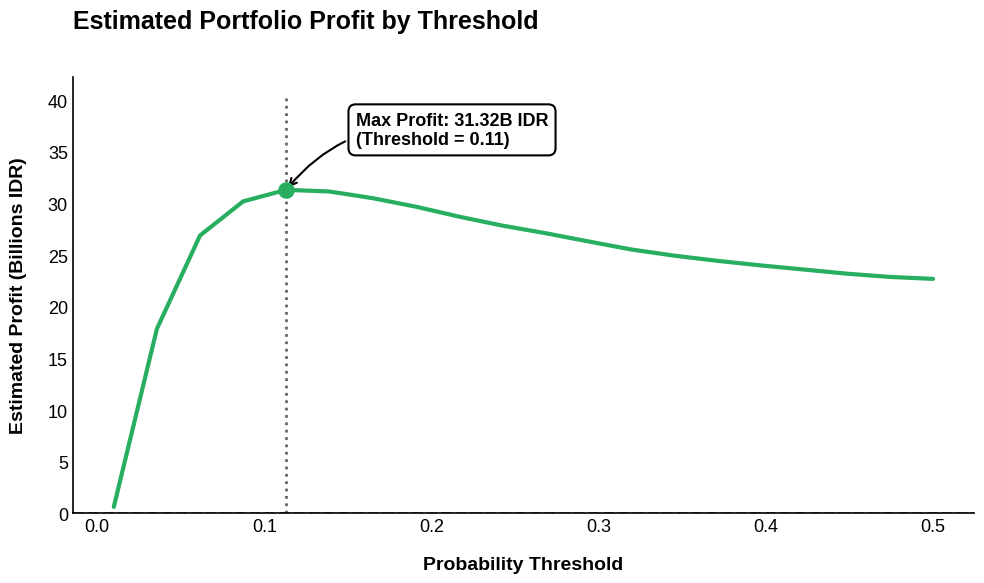

Optimal Financial Threshold: 0.11


In [38]:
# PROFITABILITY SIMULATION VISUALIZATION
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(biz_df['Threshold'], biz_df['Expected_Profit'] / 1e9, 
        color='#27ae60', linewidth=3, zorder=3)

ax.axhline(0, color='black', linewidth=2, linestyle='--', alpha=0.6, zorder=2) 

ax.set_xlabel('Probability Threshold', fontsize=14, labelpad=15, color='black', fontweight='bold')
ax.set_ylabel('Estimated Profit (Billions IDR)', fontsize=14, fontweight='bold', color='black', labelpad=15)
ax.tick_params(axis='y', labelcolor='black', labelsize=13)
ax.tick_params(axis='x', labelcolor='black', labelsize=13)

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.2) 
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.2)

max_profit_idx = biz_df['Expected_Profit'].idxmax()
best_t = biz_df.loc[max_profit_idx, 'Threshold']
max_val = biz_df.loc[max_profit_idx, 'Expected_Profit'] / 1e9

ax.scatter(best_t, max_val, color='#27ae60', s=120, zorder=5)
ax.axvline(best_t, color='black', linestyle=':', linewidth=2, ymax=0.95, alpha=0.6)
ax.annotate(f'Max Profit: {max_val:.2f}B IDR\n(Threshold = {best_t:.2f})', 
            xy=(best_t, max_val), 
            xytext=(50, 30), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle="->", color='black', linewidth=1.5, connectionstyle="arc3,rad=0.3"), 
            fontsize=13, fontweight='extra bold', color='black', ha='left', va='bottom',
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=1.0, linewidth=1.5))

ax.set_ylim(bottom=min(0, biz_df['Expected_Profit'].min()/1e9 * 1.1), top=max_val * 1.35)

plt.title('Estimated Portfolio Profit by Threshold', fontsize=18, fontweight='bold', pad=35, loc='left', color='black')

plt.tight_layout()
plt.savefig(FIG_DIR / 'profitability_curve_final_perfected.png', dpi=150)
plt.show()

print(f"Optimal Financial Threshold: {best_t:.2f}")

### 17. Conclusion & Recommendations

**Key Insights:**
1.  **Model Performance**: HistGradientBoosting outperforms Logistic Regression (AUC 0.77), confirming that non-linear relationships are crucial in credit risk modeling.
2.  **Risk Drivers**: External Data sources (`EXT_SOURCE`) and Bureau History (`bur_days_credit`) are the strongest predictors, validating the importance of integrated data.
3.  **Financial Strategy (Profit Maximization)**:
    - Our simulation reveals that the **Optimal Threshold is 0.11**.
    - At this cutoff, we maximize the projected portfolio profit to **~31.32 Billion IDR**.
    - **Recommendation**: Shift from the conservative 0.08-0.10 range to **0.11**. This slightly increases risk but significantly boosts revenue volume, outweighing the cost of additional defaults.

**Next Steps:**
- **Pilot Deployment**: Apply the 0.11 threshold on a challenger group (10% traffic) to verify real-world performance.
- **Data Enrichment**: Prioritize integrating real-time API connections for `EXT_SOURCE` data.